# Processing and generating dataset for SPARK database

The database can be found [here](https://www.collaborativedrug.com/spark-data-downloads).
The following files were used for this analysis:
* SPARK Data Achaogen Contribution.csv
* SPARK Data Merck & Kyorin Contribution.csv
* SPARK Data Novartis Contribution.csv
* SPARK Data Quave Lab {Emory University} Publications.csv
* SPARK MIC Data.csv

In [1]:
import os
import math
import json
import pandas as pd
import numpy as np
from rdkit.Chem import MolFromSmiles, MolToInchiKey
from utils import draw_venn, process_spark_data
import matplotlib.pyplot as plt

from tqdm import tqdm

tqdm.pandas()
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
DATA_DIR = "../data"

In [3]:
main_data = []

In [4]:
for file in tqdm(os.listdir(f"{DATA_DIR}/raw")):
    if not file.startswith("SPARK"):
        continue

    df = process_spark_data(file=file)
    if df.empty:
        continue

    main_data.append(df)

100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


In [5]:
spark_df = pd.concat(main_data, ignore_index=True)
spark_df.head()

,compound_name,smiles,standard_relation,standard_value,standard_units,bact_class,organism
0,SPK-0102928,NC[C@@H]1O[C@H](O[C@@H]2[C@@H](CO)O[C@@H](O[C@...,=,1.0,ug.mL-1,gram-positive,NaN
1,SPK-0102551,CO[C@@H]1[C@@H](OC(N)=O)[C@@H](O)[C@H](OC2=C(C...,=,1.0,ug.mL-1,gram-positive,NaN
2,SPK-0005427,CN(C)[C@H]1[C@@H]2C[C@H]3C(=C(O)[C@]2(O)C(=O)C...,=,1.0,ug.mL-1,gram-positive,NaN
3,SPK-0005408,C[C@@H]1[C@H](O)CC[C@@]2(C)[C@H]1CC[C@@]1(C)[C...,=,1.0,ug.mL-1,gram-positive,NaN
4,SPK-0005380,C[C@@H]1O[C@@H]1P(O)(O)=O,=,1.0,ug.mL-1,gram-positive,NaN


# Subsetting to only exact values

In [6]:
m = spark_df["standard_relation"] == "="
spark_df = spark_df[m]

In [7]:
bacterial_species = json.load(open(f"{DATA_DIR}/mapping/bact_mapper.json"))
len(bacterial_species)

2052

In [8]:
bact_class = []

for class_name, species in spark_df[["bact_class", "organism"]].values:
    if pd.notna(class_name):
        bact_class.append(class_name)

    elif species in bacterial_species:
        bact_class.append(bacterial_species[species])

    else:
        bact_class.append(np.nan)

spark_df["bact_class"] = bact_class

# Normalizing to pMIC values

In [9]:
spark_df["standard_units"] = spark_df["standard_units"].replace("ug.mL-1", "uM")

In [10]:
def calculate_pmic(row):
    activity = row["standard_value"]
    if isinstance(activity, str):
        if ">=" in activity:
            activity = 0
        elif "=" in activity:
            activity = activity.split("=")[1]
        elif ">" in activity:
            activity = activity.split(">")[1]
        elif "<" in activity:
            activity = 0

    if activity == 0.0:
        return 0
    elif row["standard_units"] == "nM" and pd.notna(activity):
        return round(9 - math.log10(float(activity)))
    elif row["standard_units"] == "uM" and pd.notna(activity):
        return round(6 - math.log10(float(activity)))
    elif row["standard_units"] == "mM" and pd.notna(activity):
        return round(3 - math.log10(float(activity)))
    else:
        return 0


spark_df["pmic"] = spark_df.apply(calculate_pmic, axis=1)

In [11]:
# Since some values are not converted to float, we will convert them to float
vals = []

for i in spark_df["standard_value"]:
    if isinstance(i, str):
        if ">=" in i:
            i = i.split(">=")[1]
        elif "=" in i:
            i = i.split("=")[1]
        elif ">" in i:
            i = i.split(">")[1]
        elif "<" in i:
            i = i.split("<")[1]

        vals.append(float(i))
    else:
        vals.append(float(i))

spark_df["standard_value"] = vals

In [12]:
# Removing empty values
spark_df = spark_df[spark_df["pmic"] != 0]

<AxesSubplot: ylabel='Frequency'>

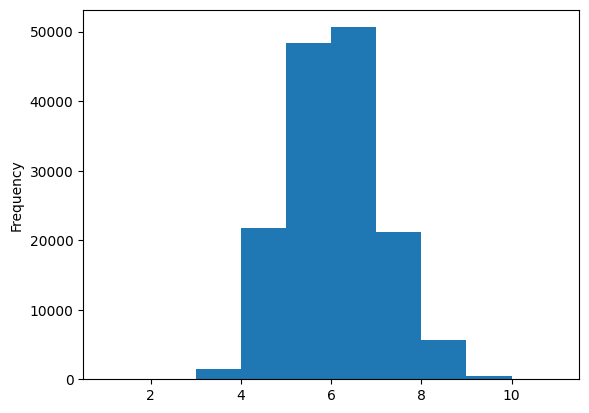

In [13]:
spark_df["pmic"].plot(kind="hist")

In [14]:
spark_df["bact_class"].value_counts()

gram-negative    137651
gram-positive     11630
acid-fast           305
fungi                 2
Name: bact_class, dtype: int64

# Overlap across categories

In [15]:
spark_df.replace("nan", np.nan, inplace=True)
spark_df.drop_duplicates(inplace=True)

In [16]:
compound_idx_dict = {}

for spark_id, class_name in tqdm(spark_df[["compound_name", "bact_class"]].values):
    if class_name not in compound_idx_dict:
        compound_idx_dict[class_name] = set()

    compound_idx_dict[class_name].add(spark_id)

100%|██████████| 88683/88683 [00:00<00:00, 1771710.16it/s]


In [17]:
total_compounds = set()
for i in compound_idx_dict:
    print(i, len(compound_idx_dict[i]))
    total_compounds.update(compound_idx_dict[i])

print(f"Total compounds: {len(total_compounds)}")

gram-positive 3085
gram-negative 13826
acid-fast 162
fungi 2
Total compounds: 14629


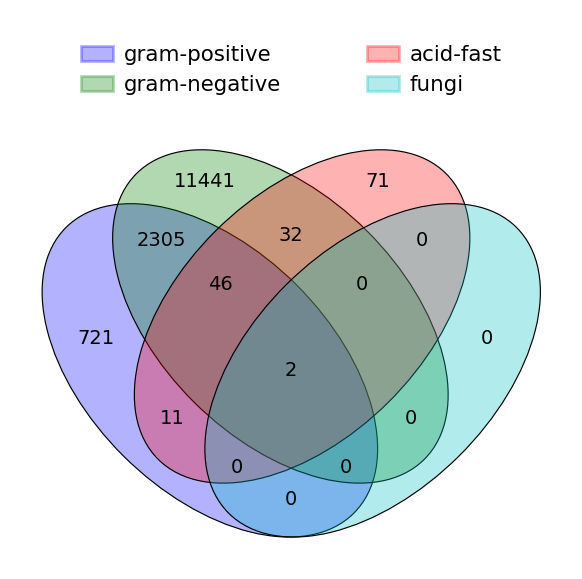

In [18]:
draw_venn(sets=compound_idx_dict)

# Finalizing data

In [19]:
# Adding in inchikey to be consistent with other datasets
def get_inchikey(smiles):
    mol = MolFromSmiles(smiles)
    if mol:
        return MolToInchiKey(mol)
    return None


spark_df["compound_inchikey"] = spark_df["smiles"].progress_apply(get_inchikey)

100%|██████████| 88683/88683 [00:24<00:00, 3582.82it/s]


In [20]:
spark_df.to_csv(f"{DATA_DIR}/processed/spark_raw_data.tsv", sep="\t", index=False)

In [21]:
data = []

for smile in tqdm(spark_df["smiles"].unique()):
    tmp = spark_df[spark_df["smiles"] == smile]

    data_dict = {
        "compound_smiles": smile,
        "compound_source": "spark",
        "compound_inchikey": tmp["compound_inchikey"].values[0],
    }

    for bact_class_name in ["gram-positive", "gram-negative", "fungi", "acid-fast"]:
        t = tmp[tmp["bact_class"] == bact_class_name]
        if t.shape[0] == 0:
            data_dict[bact_class_name] = None
        elif t.shape[0] == 1:
            data_dict[bact_class_name] = t["pmic"].values[0]
        else:
            data_dict[bact_class_name] = t["pmic"].median()

    data.append(data_dict)

100%|██████████| 14629/14629 [00:38<00:00, 377.36it/s]


In [22]:
final_df = pd.DataFrame(data)
final_df.head()

,compound_smiles,compound_source,compound_inchikey,gram-positive,gram-negative,fungi,acid-fast
0,NC[C@@H]1O[C@H](O[C@@H]2[C@@H](CO)O[C@@H](O[C@...,spark,UOZODPSAJZTQNH-LSWIJEOBSA-N,5.5,5.0,NaN,NaN
1,CO[C@@H]1[C@@H](OC(N)=O)[C@@H](O)[C@H](OC2=C(C...,spark,YJQPYGGHQPGBLI-KGSXXDOSSA-N,6.0,5.0,NaN,NaN
2,CN(C)[C@H]1[C@@H]2C[C@H]3C(=C(O)[C@]2(O)C(=O)C...,spark,OFVLGDICTFRJMM-WESIUVDSSA-N,7.0,6.0,NaN,NaN
3,C[C@@H]1[C@H](O)CC[C@@]2(C)[C@H]1CC[C@@]1(C)[C...,spark,IECPWNUMDGFDKC-MZJAQBGESA-N,6.0,5.0,NaN,NaN
4,C[C@@H]1O[C@@H]1P(O)(O)=O,spark,YMDXZJFXQJVXBF-STHAYSLISA-N,6.0,4.0,NaN,NaN


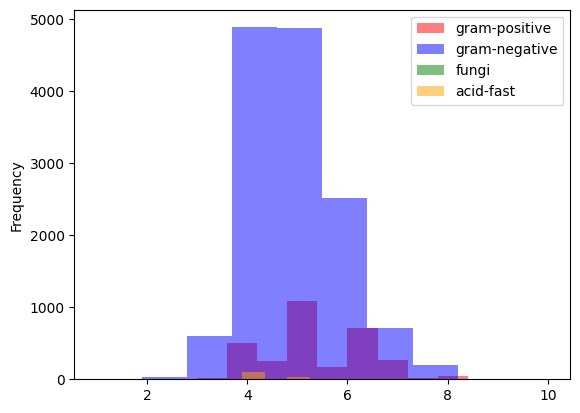

In [23]:
fig, ax = plt.subplots(1, 1)
final_df["gram-positive"].plot(kind="hist", ax=ax, alpha=0.5, color="red")
final_df["gram-negative"].plot(kind="hist", ax=ax, alpha=0.5, color="blue")
final_df["fungi"].plot(kind="hist", ax=ax, alpha=0.5, color="green")
final_df["acid-fast"].plot(kind="hist", ax=ax, alpha=0.5, color="orange")
plt.legend()
plt.show()

In [24]:
final_df.to_csv(f"{DATA_DIR}/processed/bacterial_spark.tsv", sep="\t", index=False)